In [1]:
# pip install cgal
from __future__ import print_function
from CGAL.CGAL_Kernel import Point_3
from CGAL.CGAL_Kernel import Plane_3
from CGAL import CGAL_Convex_hull_3
from CGAL.CGAL_Polyhedron_3 import Polyhedron_3

pts = []
pts.append(Point_3(0, 0, 0))
pts.append(Point_3(0, 1, 0))
pts.append(Point_3(1, 1, 0))
pts.append(Point_3(1, 0, 0))
pts.append(Point_3(0, 0, 1))
pts.append(Point_3(0, 1, 1))
pts.append(Point_3(1, 1, 1))
pts.append(Point_3(1, 0, 1))

res = Polyhedron_3()

CGAL_Convex_hull_3.convex_hull_3(pts, res)

print("convex hull has ", res.size_of_vertices(), " vertices")
print("is strongly convex: ", CGAL_Convex_hull_3.is_strongly_convex_3(res))

planes = []
planes.append(Plane_3(-1, 0, 0, 0))
planes.append(Plane_3(1, 0, 0, -1))
planes.append(Plane_3(0, -1, 0, 0))
planes.append(Plane_3(0, 1, 0, -1))
planes.append(Plane_3(0, 0, -1, 0))
planes.append(Plane_3(0, 0, 1, -1))

res.clear()
CGAL_Convex_hull_3.halfspace_intersection_3(planes, res)
print("halfspace intersection has ", res.size_of_vertices(), " vertices")

convex hull has  8  vertices
is strongly convex:  True
halfspace intersection has  8  vertices


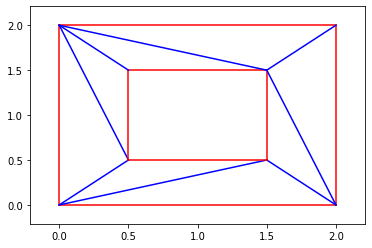

In [2]:
# This code is a python re-implementation of an example entitled
# "Triangulating a Polygonal Domain" from the CGAL documentation,
# in the Chapter entitled "2D Triangulation"
from __future__ import print_function
from CGAL.CGAL_Kernel import Point_2
from CGAL.CGAL_Triangulation_2 import Constrained_Delaunay_triangulation_2


class FaceInfo2(object):
    def __init__(self):
        self.nesting_level = -1

    def in_domain(self):
        return (self.nesting_level % 2) != 1


def mark_domains(ct, start_face, index, edge_border, face_info):
    if face_info[start_face].nesting_level != -1:
        return
    queue = [start_face]
    while queue != []:
        fh = queue[0]  # queue.front
        queue = queue[1:]  # queue.pop_front
        if face_info[fh].nesting_level == -1:
            face_info[fh].nesting_level = index
            for i in range(3):
                e = (fh, i)
                n = fh.neighbor(i)
                if face_info[n].nesting_level == -1:
                    if ct.is_constrained(e):
                        edge_border.append(e)
                    else:
                        queue.append(n)


def mark_domain(cdt):
    """Find a mapping that can be tested to see if a face is in a domain
    Explore the set of facets connected with non constrained edges,
    and attribute to each such set a nesting level.
    We start from the facets incident to the infinite vertex, with a
    nesting level of 0. Then we recursively consider the non-explored
    facets incident to constrained edges bounding the former set and
    increase the nesting level by 1.
    Facets in the domain are those with an odd nesting level.
    """
    face_info = {}
    for face in cdt.all_faces():
        face_info[face] = FaceInfo2()
    index = 0
    border = []
    mark_domains(cdt, cdt.infinite_face(), index + 1, border, face_info)
    while border != []:
        e = border[0]  # border.front
        border = border[1:]  # border.pop_front
        n = e[0].neighbor(e[1])
        if face_info[n].nesting_level == -1:
            lvl = face_info[e[0]].nesting_level + 1
            mark_domains(cdt, n, lvl, border, face_info)
    return face_info


def insert_polygon(cdt, polygon):
    if not polygon:
        return

    handles = [cdt.insert(polypt) for polypt in polygon]
    for i in range(len(polygon) - 1):
        cdt.insert_constraint(handles[i], handles[i + 1])
    cdt.insert_constraint(handles[-1], handles[0])


if __name__ == "__main__":

    def plot_triangulated_polygon(cdt, face_info):
        # This code is an additional element which recreates the figure
        # presented in the original CGAL example. Given the ease of which
        # a standard plotting library can be installed for python, it
        # makes sense to offer some form of visualisation directly
        try:
            import matplotlib.pyplot as plt
        except Exception:
            print('plotting of triangulation not supported')
            return

        def rescale_plot(ax, scale=1.1):
            xmin, xmax = ax.get_xlim()
            ymin, ymax = ax.get_ylim()
            xmid = (xmin + xmax) / 2.0
            ymid = (ymin + ymax) / 2.0
            xran = xmax - xmid
            yran = ymax - ymid
            ax.set_xlim(xmid - xran * scale, xmid + xran * scale)
            ax.set_ylim(ymid - yran * scale, ymid + yran * scale)

        def plot_edge(edge, *args):
            edge_seg = cdt.segment(edge)
            pts = [edge_seg.source(), edge_seg.target()]
            xs = [pts[0].x(), pts[1].x()]
            ys = [pts[0].y(), pts[1].y()]
            plt.plot(xs, ys, *args)

        for edge in cdt.finite_edges():
            if cdt.is_constrained(edge):
                plot_edge(edge, 'r-')
            else:
                if face_info[edge[0]].in_domain():
                    plot_edge(edge, 'b-')
        rescale_plot(plt.gca())
        plt.show()

    def main():
        # Construct two non-intersecting nested polygons
        polygon1 = [Point_2(0, 0), Point_2(2, 0), Point_2(2, 2), Point_2(0, 2)]

        polygon2 = [
            Point_2(0.5, 0.5),
            Point_2(1.5, 0.5),
            Point_2(1.5, 1.5),
            Point_2(0.5, 1.5)
        ]

        # Insert the polygons into a constrained triangulation
        cdt = Constrained_Delaunay_triangulation_2()
        insert_polygon(cdt, polygon1)
        insert_polygon(cdt, polygon2)

        # Mark facest that are inside the domain bounded by the polygon
        face_info = mark_domain(cdt)

        plot_triangulated_polygon(cdt, face_info)

    main()

IsSimple:  True
IsConvex:  True
IsClockwiseOriented:  False
IsCounterClockwiseOriented:  True
Area:  3.0
Orientation:  1
Edges:
0 0 1 0
1 0 2 1
2 1 1 2
1 2 0 2
0 2 0 0
Vertices:
0 0
1 0
2 1
1 2
0 2
Intersection:
1.69 1.31
-0 0.183333


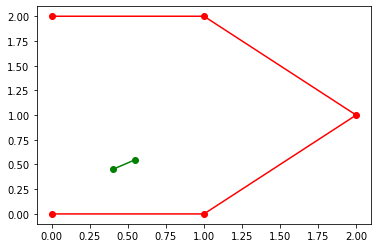

In [87]:
# Create a polygon
# Create a line
# Find intersection point of a line with polygon
# Find sweep optimal direction
# Sweep point based on the line offset
from CGAL.CGAL_Kernel import Polygon_2, Line_2, Segment_2, Point_2, do_intersect, intersection, squared_distance, Polygon_2_Vertex_circulator
import matplotlib.pyplot as plt

pg1 = Polygon_2([Point_2(0, 0), Point_2(1, 0), Point_2(2, 1), Point_2(1, 2), Point_2(0, 2)])
print("IsSimple: ", pg1.is_simple())
print("IsConvex: ", pg1.is_convex())
print("IsClockwiseOriented: ", pg1.is_clockwise_oriented())
print("IsCounterClockwiseOriented: ", pg1.is_counterclockwise_oriented())
print("Area: ", pg1.area())
print("Orientation: ", pg1.orientation())

print('Edges:')
for e in pg1.edges():
    print(e)
    
print('Vertices:')
for v in pg1.vertices():
    print(v)

x = []
y = []
for v in pg1.vertices():
    x.append(v.x())
    y.append(v.y())

l1 = Line_2(Point_2(0.4, 0.45), Point_2(0.55, 0.55)) # Eq of line passing through points
ls1 = Segment_2(Point_2(0.4, 0.45), Point_2(0.55, 0.55)) # line segement
plt.plot(x, y, '-ro')
plt.plot([ls1.source().x(), ls1.target().x()], [ls1.source().y(), ls1.target().y()], '-go')
# plt.plot([l1.source().x(), l1.target().x()], [l1.source().y(), l1.target().y()], '-go')
# print(l1.point(1))

print('Intersection:')
for e in pg1.edges():
    obj = intersection(e, l1)
    # print(do_intersect(e, ls1))
    # print(dir(intersection(e, l1)))
    if obj.is_Point_2():
        pt = obj.get_Point_2()
        print(pt)

In [107]:
def find_south(pg: Polygon_2, ln:Line_2):
    vc = pg.vertices_circulator()
    done = vc.next()
    v = pg.vertices_circulator()
    while True:
        p = vc.next()
        q = v.next()
        if squared_distance(ln, p) < squared_distance(ln, q):
            v = vc
        else:
            v = v;
            
        if vc.next() == done:
            break
        
    return vc

def find_north(pg: Polygon_2, ln:Line_2):
    return find_south(pg, ln.opposite())

def is_weakly_monotone(pg: Polygon_2, ln:Line_2):
    pass

def get_all_sweepable_edge_directions(pg: Polygon_2):
    pass

# Sort vertices of polygon based on signed distance to line l.
def sort_vertices_to_line(pg: Polygon_2, ln:Line_2):
    pts = []
    for v in pg.vertices():
        pts.append(v)
        
    # SORT: returns true iff the signed distance of p and l is smaller than the signed distance of q and l. 
    from functools import cmp_to_key
    sorted(pts, key=cmp_to_key(lambda p,q: squared_distance(ln, p) < squared_distance(ln,q)))
    return pts

# Find the intersections between a polygon and a line and sort them by the
# distance to the perpendicular direction of the line.
def find_intersections(pg: Polygon_2, ln:Line_2):
    pts = []
    for e in pg.edges():
        obj = intersection(e, ln)
        if obj.is_Segment_2():
            ls = obj.get_Segment_2()
            pts.append(ls.source())        
            pts.append(ls.target())        
            
        elif obj.is_Point_2():
            pts.append(obj.get_Point_2())        
            
    # SORT: returns true iff the signed distance of p and l is smaller than the signed distance of q and l. 
    from functools import cmp_to_key
    perp_ln = ln.perpendicular(ln.point(0));
    sorted(pts, key=cmp_to_key(lambda p,q: squared_distance(perp_ln, p) < squared_distance(perp_ln, q)))
    return pts

# Same as findIntersections but only return first and last intersection.
def find_sweep_segment(pg: Polygon_2, ln:Line_2):
    pts = find_intersections(pg, ln)
    if len(pts) == 0:
        return False, None
    lsg = Segment_2(pts[0], pts[-1]) # Front and Back
    return True, lsg

# for pt in sort_vertices_to_line(pg1, l1):
    # print(f"{pt.x():+0.2f}, {pt.y():+0.2f}")
    
# for pt in find_intersections(pg1, l1):
#     print(f"{pt.x():+0.2f}, {pt.y():+0.2f}")

# result, ls2 = find_sweep_segment(pg1, l1)
# print(f"find_sweep_segment: {result}, {ls2.source()}, {ls2.target()}")

v = find_south(pg1, l1)
print(v.next())

1 0
